# 211013 Analysis

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import h5py as h5
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Setup

In [4]:
infiles = dict(
    genomes=Path('data-processed/211015-combine-data/211015-gambit-ani-genomes.csv'),
    data=Path('data-intermediate/211015-combine-data/data.nc'),
)

## Code

In [5]:
def get_datasets(group):
    return {name: child[:] for name, child in group.items()}

In [6]:
def with_dims(ds, dims):
    todrop = ds.dims.keys() - dims
    return ds.drop_dims(todrop)

In [7]:
def pairs_to_matrix(xa, dim1, dim2):
    assert xa.ndim == 1
    g1 = xa.coords['g1']
    g2 = xa.coords['g2']
    n = g1.max().item() + 1
    
    mat = np.empty((n, n), dtype=xa.dtype)
    mat[g1, g2] = xa.values
    mat[g2, g1] = xa.values
    
    return xr.DataArray(mat, dims=[dim1, dim2])

In [8]:
def pairs2_to_matrix(xa1, xa2, dim1, dim2):
    assert xa1.ndim == 1
    assert xa2.ndim == 1
    g1 = xa1.coords['g1']
    g2 = xa1.coords['g2']
    n = g1.max().item() + 1
    
    mat = np.empty((n, n), dtype=xa1.dtype)
    mat[g1, g2] = xa1.values
    mat[g2, g1] = xa2.values
    
    return xr.DataArray(mat, dims=[dim1, dim2])

In [9]:
def leaf_order(link):
    return dendrogram(link, no_plot=True)['leaves']

def order_dmat(dmat, link):
    leaves = leaf_order(link)
    return dmat[np.ix_(leaves, leaves)]

In [10]:
def connected_components(edges):
    components = dict()
    cmap = dict()
    cnext = 0
    
    for a, b in edges:
        ac = cmap.get(a)
        bc = cmap.get(b)
        
        if ac is None and bc is None:
            components[cnext] = {a, b}
            cmap[a] = cnext
            cmap[b] = cnext
            cnext += 1
            
        elif ac is None:
            cmap[a] = bc
            components[bc].add(a)
            
        elif bc is None:
            cmap[b] = ac
            components[ac].add(b)
            
        elif ac != bc:
            for x in components[bc]:
                cmap[x] = ac
            components[ac] |= components[bc]
            del components[bc]
            
    for c, nodes in components.items():
        for x in nodes:
            assert cmap[x] == c
            
    return list(components.values())

## Load data

### Genomes

In [11]:
genomes = pd.read_csv(infiles['genomes'], index_col=[0, 1])

### Common

In [12]:
common_ds = xr.load_dataset(infiles['data'], group='common')

common_df = common_ds.to_dataframe(['data_set', 'param'])

In [13]:
gsets = common_ds.indexes['data_set']
ngsets = len(gsets)

### Params

In [14]:
params_df = common_ds \
    .drop_dims('data_set') \
    .to_dataframe() \
    .set_index(['prefix_len', 'prefix_version', 'k'], drop=True)

In [15]:
def get_param(prefix_len, prefix_version, k):
    return params_df.index.get_loc((prefix_len, prefix_version, k))

In [16]:
gambitdb_param = get_param(5, 0, 11)

### By genome

In [17]:
genome_dss = {gset: xr.load_dataset(infiles['data'], group='genome/' + gset) for gset in gsets}

## ANI unreported

In [18]:
has_unreported = [k for k, ds in genome_dss.items() if not ds.reported_both.all()]
has_unreported

['200726_gold_standard', 'konstantinidis_2005']

### Connected components

In [19]:
for ds in genome_dss.values():
    ds['reported_either'] = ds.reported_q1r2 | ds.reported_q2r1

In [20]:
for gset in has_unreported:
    ds = genome_dss[gset]

    edges = zip(ds.g1[ds.reported_either].values, ds.g2[ds.reported_either].values)
    ccs = connected_components(edges)
    ccs = [sorted(cc) for cc in ccs if len(cc) > 1]
    ccs.sort(key=len, reverse=True)

    gcs = ds['genome_comp'] = xr.Variable(['genome'], np.zeros(ds.dims['genome'], dtype=int))
    pcs = ds['pair_comp'] = xr.Variable(['pair'], np.zeros(ds.dims['pair'], dtype=int))
    
    for i, cc in enumerate(ccs):
        idx = ds['genome'].isin(cc)
        assert np.all(gcs[idx] == 0)
        gcs[idx] == i + 1
        
        idx2 = ds.g1.isin(cc) & ds.reported_either
        assert np.all(pcs[idx2] == 0)
        pcs[idx2] = i + 1
        
    # Distance is one for all inter-component pairs
    assert not np.any(ds['reported_either'].sel(pair=(ds['pair_comp'] == 0) & (ds.g1 != ds.g2)))

In [21]:
_dfs = []

for gset in has_unreported:
    ds = genome_dss[gset]
    
    _df = ds[['dist', 'reported_either']] \
        .sel(param=gambitdb_param) \
        .sel(pair=ds.g1 != ds.g2) \
        .to_dataframe()

    _df['score'] = 1 - _df['dist']

    _df['component'] = 0
    _df['pair'] = 'inter'
    for i, cc in enumerate(ccs):
        if len(cc) < 5:
            break
        
        idx = _df.g1.isin(cc) & _df.reported_either
        _df.loc[idx, 'component'] = i + 1
        _df.loc[idx, 'pair'] = f'within {i + 1}'
        
    # Zero scores are all for inter-component pairs
    assert np.all(_df.loc[_df['score'] == 0, 'component'] == 0)
        
    _dfs.append(_df)

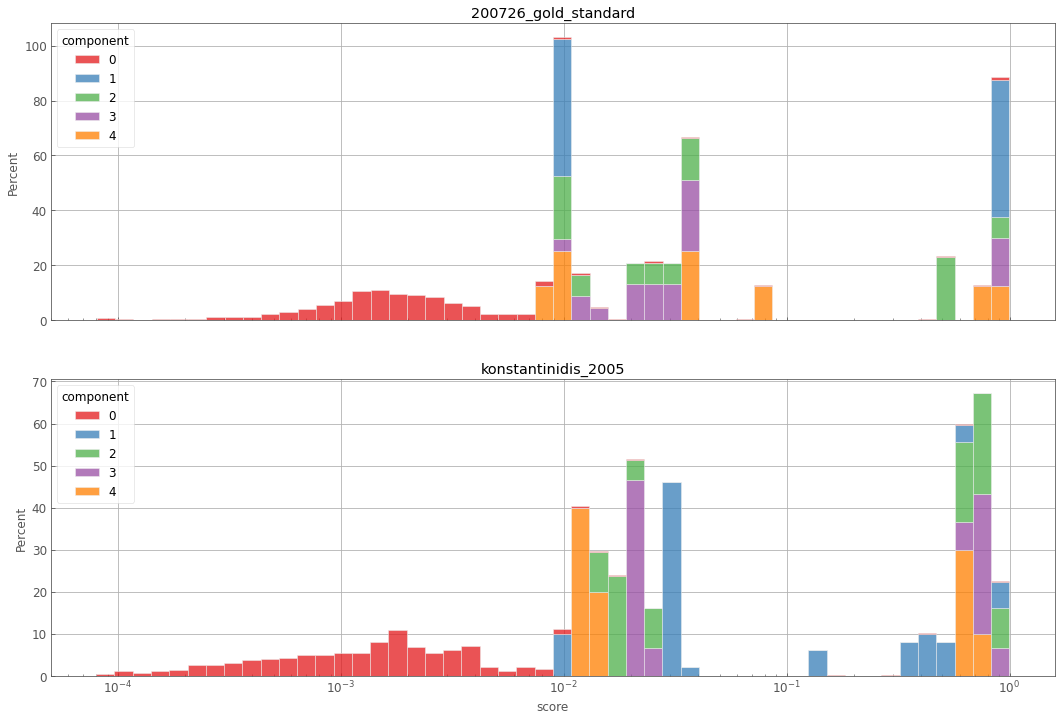

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

for _df, ax, gset in zip(_dfs, axs, has_unreported):
    sns.histplot(
        ax=ax,
        data=_df[_df['score'] != 0],
        x='score',
        hue='component',
        stat='percent',
        bins=50,
    #     element='step',
        log_scale=True,
        multiple='stack',
        common_norm=False,
        palette='Set1',
    )
    
    ax.set_title(gset)

## ?

In [49]:
from src.esummary_store import BasicEsummaryStore

In [50]:
esummaries = BasicEsummaryStore('assembly', '/home/jared/projects/gambit/data/ncbi/assembly/esummary/')

In [52]:
next(iter(esummaries.values()))

{'uid': '467788',
 'rsuid': '467788',
 'gbuid': '316998',
 'assemblyaccession': 'GCF_000235225.1',
 'lastmajorreleaseaccession': 'GCF_000235225.1',
 'latestaccession': '',
 'chainid': '235225',
 'assemblyname': 'Esch_coli_09-7901_V2',
 'ucscname': '',
 'ensemblname': '',
 'taxid': '1048266',
 'organism': 'Escherichia coli O104:H4 str. 09-7901 (E. coli)',
 'speciestaxid': '562',
 'speciesname': 'Escherichia coli',
 'assemblytype': 'haploid',
 'assemblyclass': 'haploid',
 'assemblystatus': 'Scaffold',
 'assemblystatussort': 5,
 'wgs': 'AFRK01',
 'gb_bioprojects': [{'bioprojectaccn': 'PRJNA68213', 'bioprojectid': 68213}],
 'gb_projects': [],
 'rs_bioprojects': [{'bioprojectaccn': 'PRJNA224116', 'bioprojectid': 224116}],
 'rs_projects': [],
 'biosampleaccn': 'SAMN00715302',
 'biosampleid': '715302',
 'biosource': {'infraspecieslist': [{'sub_type': 'strain',
    'sub_value': '09-7901'}],
  'sex': '',
  'isolate': ''},
 'coverage': '214',
 'partialgenomerepresentation': 'false',
 'primary': 

In [26]:
from Bio import Entrez

In [32]:
import json

In [28]:
Entrez.email = 'mjlumpe@gmail.com'
Entrez.api_key = 'adea2a53e6e44c3cc42c932f9ba4bdffa809'

In [53]:
with Entrez.esummary(db='taxonomy', id=1048266, retmode='json') as f:
    data = json.load(f)

In [55]:
data = Entrez.read(Entrez.efetch(db='taxonomy', id=1048266))

In [56]:
data[0]

{'TaxId': '1048266', 'ScientificName': 'Escherichia coli O104:H4 str. 09-7901', 'OtherNames': {'GenbankAnamorph': [], 'Misnomer': [], 'Synonym': [], 'Teleomorph': [], 'Acronym': [], 'CommonName': [], 'Misspelling': [], 'Inpart': [], 'Name': [], 'Anamorph': [], 'EquivalentName': ['Escherichia coli O104:H4 strain 09-7901'], 'GenbankSynonym': [], 'Includes': []}, 'ParentTaxId': '1038927', 'Rank': 'strain', 'Division': 'Bacteria', 'GeneticCode': {'GCId': '11', 'GCName': 'Bacterial, Archaeal and Plant Plastid'}, 'MitoGeneticCode': {'MGCId': '0', 'MGCName': 'Unspecified'}, 'Lineage': 'cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Enterobacterales; Enterobacteriaceae; Escherichia; Escherichia coli; Escherichia coli O104:H4', 'LineageEx': [{'TaxId': '131567', 'ScientificName': 'cellular organisms', 'Rank': 'no rank'}, {'TaxId': '2', 'ScientificName': 'Bacteria', 'Rank': 'superkingdom'}, {'TaxId': '1224', 'ScientificName': 'Proteobacteria', 'Rank': 'phylum'}, {'TaxId': '123

In [57]:
list(data[0]['LineageEx'])

[{'TaxId': '131567', 'ScientificName': 'cellular organisms', 'Rank': 'no rank'},
 {'TaxId': '2', 'ScientificName': 'Bacteria', 'Rank': 'superkingdom'},
 {'TaxId': '1224', 'ScientificName': 'Proteobacteria', 'Rank': 'phylum'},
 {'TaxId': '1236', 'ScientificName': 'Gammaproteobacteria', 'Rank': 'class'},
 {'TaxId': '91347', 'ScientificName': 'Enterobacterales', 'Rank': 'order'},
 {'TaxId': '543', 'ScientificName': 'Enterobacteriaceae', 'Rank': 'family'},
 {'TaxId': '561', 'ScientificName': 'Escherichia', 'Rank': 'genus'},
 {'TaxId': '562', 'ScientificName': 'Escherichia coli', 'Rank': 'species'},
 {'TaxId': '1038927', 'ScientificName': 'Escherichia coli O104:H4', 'Rank': 'serotype'}]

In [48]:
!ls tmp

fastani  gambit  genomes


In [45]:
dict(_)

{'TaxId': '1755381',
 'ScientificName': 'Norovirus Hu/GII.4_variant Sydney 2012/NZ13729/2013/NZ',
 'ParentTaxId': '489821',
 'Rank': 'no rank',
 'Division': 'Viruses',
 'GeneticCode': {'GCId': '1', 'GCName': 'Standard'},
 'MitoGeneticCode': {'MGCId': '0', 'MGCName': 'Unspecified'},
 'Lineage': 'Viruses; Riboviria; Orthornavirae; Pisuviricota; Pisoniviricetes; Picornavirales; Caliciviridae; Norovirus; Norwalk virus; Norovirus GII; Norovirus GII.4',
 'LineageEx': [{'TaxId': '10239', 'ScientificName': 'Viruses', 'Rank': 'superkingdom'}, {'TaxId': '2559587', 'ScientificName': 'Riboviria', 'Rank': 'clade'}, {'TaxId': '2732396', 'ScientificName': 'Orthornavirae', 'Rank': 'kingdom'}, {'TaxId': '2732408', 'ScientificName': 'Pisuviricota', 'Rank': 'phylum'}, {'TaxId': '2732506', 'ScientificName': 'Pisoniviricetes', 'Rank': 'class'}, {'TaxId': '464095', 'ScientificName': 'Picornavirales', 'Rank': 'order'}, {'TaxId': '11974', 'ScientificName': 'Caliciviridae', 'Rank': 'family'}, {'TaxId': '142786

In [41]:
data2

b'1755381\n'

In [37]:
with Entrez.esummary(db='taxonomy', id=1755381) as f:
    data3 = f.read()

In [39]:
print(data3.decode())

<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eSummaryResult PUBLIC "-//NLM//DTD esummary v1 20041029//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20041029/esummary-v1.dtd">
<eSummaryResult>
<DocSum>
	<Id>1755381</Id>
	<Item Name="Status" Type="String">active</Item>
	<Item Name="Rank" Type="String">isolate</Item>
	<Item Name="Division" Type="String">viruses</Item>
	<Item Name="ScientificName" Type="String">Norovirus Hu/GII.4_variant Sydney 2012/NZ13729/2013/NZ</Item>
	<Item Name="CommonName" Type="String"></Item>
	<Item Name="TaxId" Type="Integer">1755381</Item>
	<Item Name="AkaTaxId" Type="Integer">0</Item>
	<Item Name="Genus" Type="String"></Item>
	<Item Name="Species" Type="String"></Item>
	<Item Name="Subsp" Type="String"></Item>
	<Item Name="ModificationDate" Type="Date">2015/11/20 00:00</Item>
</DocSum>

</eSummaryResult>



In [ ]:
print(data2.decode())

In [ ]:
esummaries['1755381']